# Predict Breakpoints in pump sensor data using LSTM Autoencoder

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers


In [42]:
# If true, you can resume model analysis  by loading pretrained weights
MODE_RESUME = False #True # False


# --- Pre-Processing ---
LABELS = ["Normal","Break"]

# For randomizing
RANDOM_SEED = 101 

# Split Percentage
SPLIT_PREC = 0.2

# Time (in n-rows) for which to predict ahead (X * 1min)
# 
PREDICT_AHEAD_ROWS = 101

# --- Modeling ---
# Lookback/Timestep for LSTM Model (X * 1min)
LOOKBACK = 15

N_EPOCHS = 50 #200
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# Load Cleaned Dataset

In [3]:
PATH_DATA = "../data/sensor_cleaned.csv"

df_data = pd.read_csv(PATH_DATA)

print(df_data.shape)

df_data

(220320, 51)


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,30.468750,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,30.208332,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,29.947920,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,29.947916,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NORMAL


In [4]:
df_data['datetime'] = pd.to_datetime(df_data['timestamp'])
df_data.sort_values(by='datetime', ascending=True)

df_data

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,datetime
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:00:00
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:01:00
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL,2018-04-01 00:02:00
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL,2018-04-01 00:03:00
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NORMAL,2018-08-31 23:55:00
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NORMAL,2018-08-31 23:56:00
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NORMAL,2018-08-31 23:57:00
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NORMAL,2018-08-31 23:58:00


In [5]:
df_data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

# 1. Pre-Process

## 1.1 Label rows as per machine status

Mark all rows with status 'NORMAL' & 'RECOVERING' as 0 and 'BROKEN' as 1 in a new column.

In [6]:
MAP_LABEL = {
    'NORMAL': 0,
    'RECOVERING': 0,
    'BROKEN': 1
}

df_data['y'] = df_data['machine_status'].apply(lambda v: MAP_LABEL[v])

df_data

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,datetime,y
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:00:00,0
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:01:00,0
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL,2018-04-01 00:02:00,0
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL,2018-04-01 00:03:00,0
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL,2018-04-01 00:04:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NORMAL,2018-08-31 23:55:00,0
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NORMAL,2018-08-31 23:56:00,0
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NORMAL,2018-08-31 23:57:00,0
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NORMAL,2018-08-31 23:58:00,0


## 1.2 Curve Shifting 

**10 minutes (10 Rows)**

1. For any row 'n' with label 1, make (n-10):(n-1) as 1. With this, we are teaching the classifier to predict up to 10 minutes ahead. 
2. Remove row 'n'. Row n is removed because we are not interested in teaching the classifier to predict a break when it has already happened.

In [7]:
CHECK_IDXS = [17150, 17160]

In [8]:
df_data_new = df_data.copy()

# (1) Shift values 
y_new = df_data_new['y'].to_list()
for idx, row in df_data_new.iterrows():
    if row['y'] == 1:
        _start_idx = idx-(PREDICT_AHEAD_ROWS)
        y_new[_start_idx:idx] = [1] * (idx-_start_idx)

df_data_new['label'] = y_new


# (2) Remove rows with status 'BROKEN'
df_data_new = df_data_new.drop(df_data_new[df_data_new['machine_status'] == 'BROKEN'].index)


df_data_new[CHECK_IDXS[0]:CHECK_IDXS[1]]

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,datetime,y,label
17150,2018-04-12 21:50:00,1.533738,52.03993,52.951385,43.402775,110.975121,46.92294,13.172740,16.65220,15.661170,...,59.02778,50.92593,48.32176,42.245369,352.7199,111.9792,NORMAL,2018-04-12 21:50:00,0,1
17151,2018-04-12 21:51:00,1.349769,52.30035,52.951390,43.402770,110.512154,45.21725,13.201680,16.70284,15.892650,...,56.71296,50.34722,49.76852,42.245370,361.4005,112.8472,NORMAL,2018-04-12 21:51:00,0,1
17152,2018-04-12 21:52:00,1.290741,52.51736,52.907990,43.402775,112.595482,47.36653,13.498260,16.65220,15.653930,...,54.97685,49.47917,51.21528,41.956020,371.5278,113.4259,NORMAL,2018-04-12 21:52:00,0,1
17153,2018-04-12 21:53:00,1.220891,52.73437,52.821180,43.402775,113.174187,47.83727,13.252310,16.65220,15.733510,...,53.24074,49.47917,52.08333,42.245369,384.5486,114.0046,NORMAL,2018-04-12 21:53:00,0,1
17154,2018-04-12 21:54:00,0.000000,52.95139,52.821178,43.402775,117.109375,48.17030,5.758102,16.70284,15.530960,...,50.92593,50.34722,52.08333,42.534720,392.3611,115.4514,NORMAL,2018-04-12 21:54:00,0,1
17156,2018-04-12 21:56:00,0.000000,53.55902,52.777770,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,...,50.34722,51.21528,49.18982,49.479170,431.7130,133.1019,RECOVERING,2018-04-12 21:56:00,0,0
17157,2018-04-12 21:57:00,0.000000,53.55902,52.777770,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,...,49.76852,50.92593,48.03241,53.819440,451.3889,140.0463,RECOVERING,2018-04-12 21:57:00,0,0
17158,2018-04-12 21:58:00,0.000000,52.77777,52.690970,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,...,48.03241,50.34722,47.45370,58.159720,466.4352,144.9653,RECOVERING,2018-04-12 21:58:00,0,0
17159,2018-04-12 21:59:00,0.000000,52.60416,52.734370,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,...,47.45370,49.76852,46.58565,63.657410,474.8264,149.0162,RECOVERING,2018-04-12 21:59:00,0,0
17160,2018-04-12 22:00:00,2.424498,52.51736,52.690970,43.446180,203.567688,49.78948,7.559317,16.56539,16.239870,...,46.29630,48.03241,45.13889,75.231480,477.7199,162.6157,RECOVERING,2018-04-12 22:00:00,0,0


In [9]:
df_data_new['label'].value_counts()

0    219606
1       707
Name: label, dtype: int64

In [10]:
df_data_new

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,datetime,y,label
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:00:00,0,0
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:01:00,0,0
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL,2018-04-01 00:02:00,0,0
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL,2018-04-01 00:03:00,0,0
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL,2018-04-01 00:04:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NORMAL,2018-08-31 23:55:00,0,0
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NORMAL,2018-08-31 23:56:00,0,0
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NORMAL,2018-08-31 23:57:00,0,0
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NORMAL,2018-08-31 23:58:00,0,0


In [11]:
# Drop irreleavant columns
df_data_new.drop(columns=['timestamp', 'machine_status', 'datetime', 'y'], inplace=True)

## 1.3 Split into train, valid, and test

Note: We are splitting data into train test since we do not have enough observations. Using the same dataset, we create train and test data for this experiment. Ideally, there should be 3 files for train, test and validation.

In [12]:
input_X = df_data_new.loc[:, df_data_new.columns != 'label'].values
input_y = df_data_new['label'].values

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    input_X, 
    input_y, 
    test_size=SPLIT_PREC, 
    random_state=RANDOM_SEED
)

## 1.4 Use data with label as '0' (Normal Status) for training

In [14]:
X_train_y0 = X_train[y_train==0]
X_val_y0 = X_val[y_val==0]

print(f"Train Shape: {X_train_y0.shape}")
print(f"Val Shape: {X_val_y0.shape}")

Train Shape: (175699, 49)
Val Shape: (43907, 49)


## 1.5 Standardize the Data (Scaling)

In [15]:
scalar = StandardScaler()

X_train_y0_scaled = scalar.fit_transform(X_train_y0)
X_val_y0_scaled = scalar.transform(X_val_y0)

In [16]:
# Check Standardization
def checkStandardization(data):
    """
    A correct transformation of data (X) will ensure that the means and variances of 
    each columns are 0 and 1, respectively.
    """
        
    colwise_mean = np.mean(data, axis=0).round(6)
    colwise_var = np.var(data, axis=0)
    
    return (colwise_mean, colwise_var)


print("Train: ")
print( checkStandardization(X_train_y0_scaled) )

print("Val: ")
print( checkStandardization(X_val_y0_scaled) )

Train: 
(array([ 0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,
        0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,  0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
Val: 
(array([ 1.6070e-03,  6.0480e-03,  6.4750e-03,  3.8320e-03,  2.2780e-03,
        2.8330e-03,  2.3610e-03,  2.7860e-03,  4.7670e-03,  1.1580e-03,
        1.4670e-03,  1.6190e-03, -6.8000e-05,  3.0800e-04,  2.0400e-03,
        1.9530e-03,  2.5040e-03,  1.5440e-03,  1.1690e-03,  9.5500e-04,
        7.5000e-04,  7.0000e-04, -1.4600e-04,  7.2200e-04,  1.3000e-05,
       -1.0620e-03, -3.5390e-03,  7.6200e-04,  2.3620e-03,  3.4600e-04,
        1.7070e-03,  2.8620e-03,  3.4200e-03,  1.0000e-04,

## 1.6 Prepare Input Data for LSTM (Temporalize)

The input data to an LSTM model is a 3-dimensional array. The shape of the array is `samples` x `lookback` x `features`:

- `samples`: This is simply the number of observations, or in other words, the number of data points.
- `lookback`: LSTM models are meant to look at the past. Meaning, at time t the LSTM will process data up to (t-lookback) to make a prediction.
- `features`: It is the number of features present in the input data.

In [17]:
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x  n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    
    output_X = []
    output_y = []
    for i in range(X.shape[0] - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[(i + j + 1), :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
        
    return np.array(output_X), np.array(output_y)

In [18]:
X_train_final, y_train_final = temporalize(X_train_y0_scaled, y_train, lookback=LOOKBACK)
X_val_final, y_val_final = temporalize(X_val_y0_scaled, y_val, lookback=LOOKBACK)

print(X_train_final.shape)
print(X_val_final.shape)

(175683, 15, 49)
(43891, 15, 49)


# 2. LSTM Model

In [19]:
N_FEATS = X_train_final.shape[2]

In [20]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
if MODE_RESUME:
    raise Exception("Force Stopped! Go to the cell `[R] Resume Model`.")

Exception: Force Stopped! Go to the cell `[R] Resume Model`.

In [ ]:
# Build Model
# activation = 'relu'   # LSTM does not use CuDNN with relu
activation = 'tanh'


model = Sequential()

# Encoder
model.add( layers.LSTM(64, input_shape=(LOOKBACK, N_FEATS), activation=activation, return_sequences=True, name='encoder_lstm_1') )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(32, activation=activation, return_sequences=True, name='encoder_lstm_2') )
model.add( layers.Dropout(0.2) )

# Decoder
model.add( layers.LSTM(32, activation=activation, return_sequences=True, name='decoder_lstm_1') )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(64, activation=activation, return_sequences=True, name='decoder_lstm_2') )
model.add( layers.Dropout(0.2) )

# Output
model.add( layers.TimeDistributed( layers.Dense(N_FEATS), name='output') )


model.summary()

In [ ]:
# Compile
optimizer = optimizers.Adam(LEARNING_RATE)

model.compile(optimizer=optimizer, loss='mse')

# 3. Modeling

### 3.1 Train

In [ ]:
H = model.fit(
    x = X_train_final,
    y = X_train_final,
    epochs = N_EPOCHS,
    batch_size = BATCH_SIZE, 
    validation_data = (X_val_final, X_val_final),
    verbose=1
)

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(H.history['loss'], linewidth=2, label='Train')
plt.plot(H.history['val_loss'], linewidth=2, label='Val')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### 3.2 Save Model

In [ ]:
SUFFIX = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
DIR_MODEL = os.path.join(os.getcwd(), 'model')
PATH_MODEL = os.path.join(DIR_MODEL, f'model-pump-sensor-autoenc_{SUFFIX}.h5')
PATH_SCALAR = os.path.join(DIR_MODEL, f'scalar-{SUFFIX}.pkl')


if not os.path.exists(DIR_MODEL):
    os.makedirs(DIR_MODEL)
    

model.save(PATH_MODEL)
pickle.dump(scalar, open(PATH_SCALAR, 'wb'))


print(f"Model saved to: {PATH_MODEL}")

### [R] Resume Model 

Comment the below code if you started from scratch.

In [25]:
if MODE_RESUME:
    # Load Model from disk
    model = load_model("model/model-pump-sensor-autoenc_2021-07-19-17-39-47.h5")
    scalar = pickle.load(open('model/scalar-2021-07-19-17-39-47.pkl', 'rb'))
    
    model.summary()

### 3.3 Determine threshold to identify anomaly using 'val' set 

In [26]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)


In [27]:
X_val_scaled = scalar.transform(X_val)
X_val_scaled_temporalized, y_val_temporalized = temporalize(X_val_scaled, y_val, lookback=LOOKBACK)

In [28]:
# Predict on val data
x_val_predictions = model.predict(X_val_scaled_temporalized)

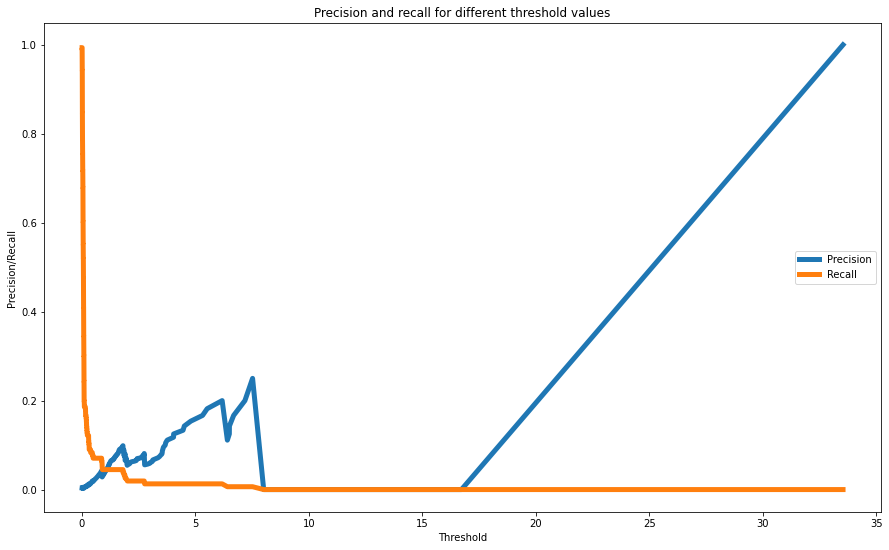

In [29]:
# Calculate MSE
mse = np.mean(np.power( flatten(X_val_scaled_temporalized) - flatten(x_val_predictions), 2), axis=1)

# df_error = pd.DataFrame({
#     'Reconstruction_error': mse,
#     'True_class': np.expand_dims(y_val, axis=1).tolist()
# })

# Get precision recall curve
precision_rt, recall_rt, threshold_rt = precision_recall_curve(
#     df_error.True_class, 
#     df_error.Reconstruction_error
    y_val_temporalized,
    mse
)

# Plot
plt.figure(figsize=(15,9))
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
# plt.xticks(threshold_rt)
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

 A threshold of `0.9` should provide a reasonable trade-off between precision and recall, as we want to higher recall.

### 3.4 Apply classification on test data

We should not estimate the classification threshold from the test data. It will result in overfitting.

_However, since we do not have enough data, we will be using `val` data as `test` data to check the hypothesis._

In [32]:
THRESHOLD = 0.9

In [33]:
# Obtain test data; Mock code
X_test_scaled = scalar.transform(X_val)
y_test = y_val

X_test_scaled_temporalized, y_test_temporalized = temporalize(X_test_scaled, y_test, lookback=LOOKBACK)

In [ ]:
# Predict test data
x_test_predictions = model.predict(X_test_scaled_temporalized)

mse = np.mean(np.power(flatten(X_test_scaled_temporalized) - flatten(x_test_predictions), 2), axis=1)

In [ ]:
df_error = pd.DataFrame({
    'Reconstruction_error': mse,
    'True_class': y_test_temporalized.tolist()
})
groups = df_error.groupby('True_class')

**Visualize Threshold**

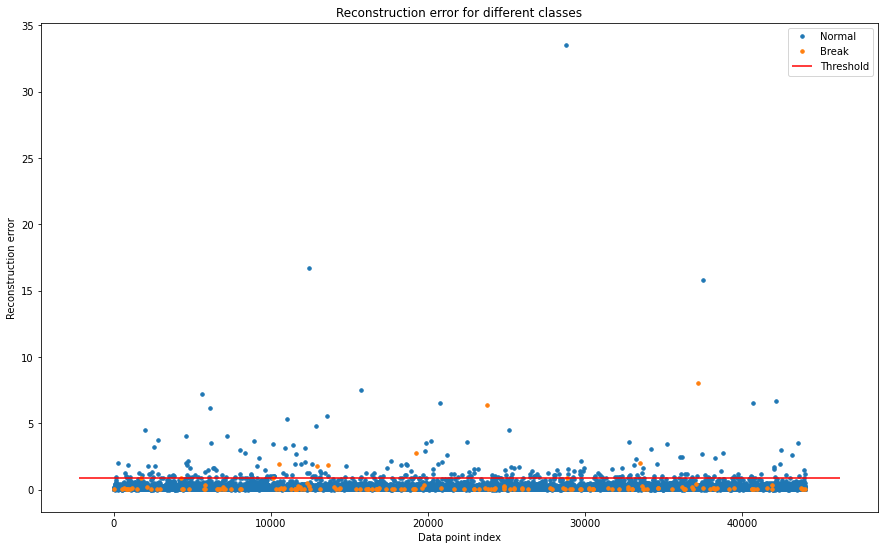

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(15,9))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Break" if name == 1 else "Normal")
    
ax.hlines(THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

The orange and blue dot above the threshold line represents the True Positive and False Positive, respectively.

**Confusion Matrix**

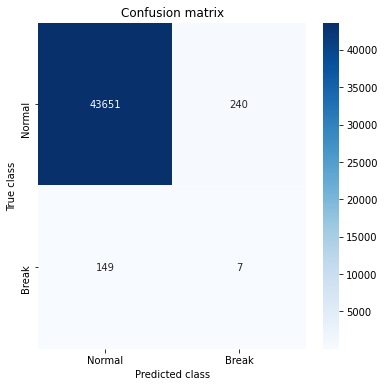

In [48]:
pred_y = [1 if e > THRESHOLD else 0 for e in df_error.Reconstruction_error.values]
conf_matrix = confusion_matrix(df_error.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**ROC Curve and AUC**

AUC: 0.5707973248414342


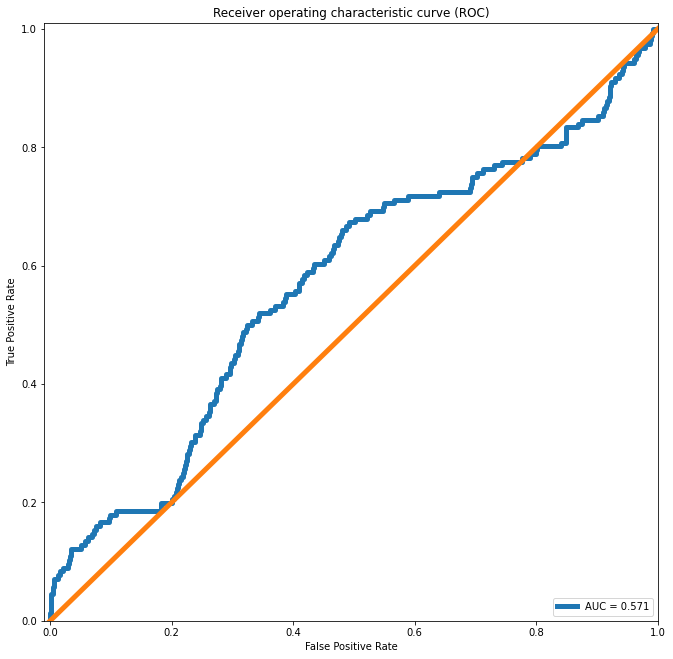

In [50]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_error.True_class, df_error.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
print(f"AUC: {roc_auc}")

plt.figure(figsize=(11,11))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()